# SJSU MSDS 255 DL, Spring 2024
Homework 08: LSTM for Time Series Prediction

Git: https://github.com/jrgosalvez/data255_DL

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Import the data from .csv file

In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
print('Number of rows and columns:', df.shape)
print()
df

Number of rows and columns: (1258, 6)



,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


<div class="alert alert-block alert-danger">
    <b>Sanity Check:</b> The <b>Close</b> feature is incorrect b/c more than 2x the High value of the day... does not make sense. Cannot close higher than the highest value of the day.
</div>

# Preprocess the data

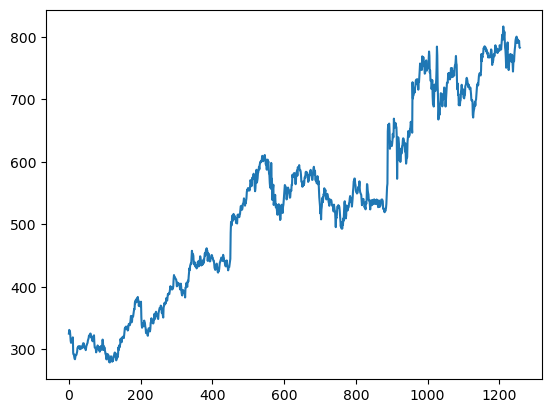

In [3]:
# Get and plot 'Open' value; feature that model will train and test on
timeseries = df[["Open"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
timeseries_scaled = sc.fit_transform(timeseries)

Because a small dataset, creating a PyTorch tensor directly from a list of numpy arrays; however, this can be slow fror complex models with large datasets. For more complicated models and larger datasets, convert list of numpy arrays into a single numpy array before converting it a tensor.

Performance is not an issue with this model, so did not preprocess furhter.

# Split into 80% train 20% prediction

In [5]:
# train-test split for timeseries data frame
train_size  = int(len(timeseries_scaled) * 0.8)
test_size   = len(timeseries_scaled) - train_size
train, test = timeseries_scaled[:train_size], timeseries_scaled[train_size:]

### Create the dataset

In [6]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test   = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1002, 4, 1]) torch.Size([1002, 4, 1])
torch.Size([248, 4, 1]) torch.Size([248, 4, 1])


# Create and train the model on the data

### Create the model

In [7]:
# LSTM model with 2 lstm layers, linear function layers and dropout regularization to mitigate overfitting

class my_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Apply dropout to the input sequence
        x = self.dropout(x)
        # Pass through LSTM layers
        x, _ = self.lstm(x)
        # Apply dropout to the LSTM output
        x = self.dropout(x)
        # Pass through linear layer
        x = self.linear(x)  # transform the entire batch of data
        # Squeeze to remove the extra dimension
        x = torch.squeeze(x, dim=1)
        return x

### Initiate the model, optimizer, and loader

In [8]:
model     = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn   = nn.MSELoss()   # linear, so MSE
loader    = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

### Train and verify LSTM model / network


In [9]:
%%time

n_epochs = 1001

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss   = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1420, test RMSE 0.2750
Epoch 100: train RMSE 0.0906, test RMSE 0.1789
Epoch 200: train RMSE 0.0909, test RMSE 0.1799
Epoch 300: train RMSE 0.0948, test RMSE 0.1866
Epoch 400: train RMSE 0.0914, test RMSE 0.1755
Epoch 500: train RMSE 0.0908, test RMSE 0.1776
Epoch 600: train RMSE 0.0943, test RMSE 0.1908
Epoch 700: train RMSE 0.0952, test RMSE 0.1734
Epoch 800: train RMSE 0.0884, test RMSE 0.1828
Epoch 900: train RMSE 0.0919, test RMSE 0.1810
Epoch 1000: train RMSE 0.0900, test RMSE 0.1794
CPU times: user 14min 42s, sys: 17.8 s, total: 15min
Wall time: 7min 39s


# Report on the results of the model

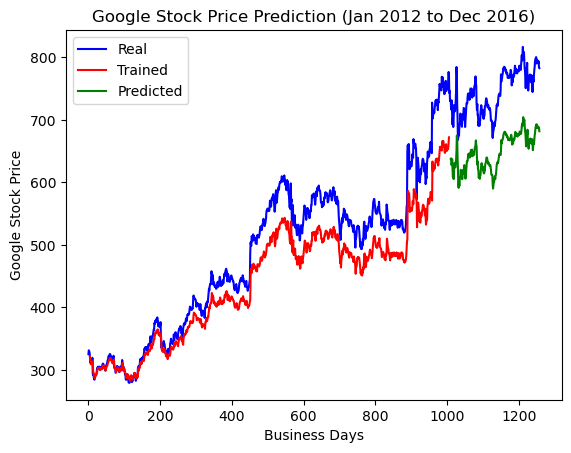

In [10]:
# Predict Google stock price on test dataset and compare to actuals

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries_scaled) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries_scaled) * np.nan
    test_plot[train_size+lookback:len(timeseries_scaled)] = model(X_test)[:, -1, :]

# Inverse transform the scaled data
real_stock_prices = sc.inverse_transform(timeseries_scaled)
predicted_train   = sc.inverse_transform(train_plot.reshape(-1, 1))
predicted_test    = sc.inverse_transform(test_plot.reshape(-1, 1))
    
plt.plot(real_stock_prices, c='b', label='Real')
plt.plot(predicted_train, c='r', label='Trained')
plt.plot(predicted_test, c='g', label='Predicted')
plt.title('Google Stock Price Prediction (Jan 2012 to Dec 2016)')
plt.xlabel('Business Days')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

Experimented with a simple model and a more complex model that added layers and dropout to regularize and generalize the model. Initial experiments ran 500 epochs each and results were compared. 

Results of the simple model were high performance, which felt unbelievable as the test data visual illustrated an overfitting pattern. 

![Results of simple LSTM with 500 epochs](Simple_lstm.png)

Based on results of the simple model, experimentation to improve the viability of performance lead to adding complexity and regularization to the model, which resulted in a more believable performance based on visual comparison for 500 epochs.

After results comparison, the better model was re-run at 2000 epochs to improve performance; however, after approximately 1000 epochs performance returns stabalized and additional epochs offered marginal returns. 

Cleaned up code and re-ran at 1000 epochs.